# Forecast de Ventas 2026: Análisis por Tipo de Suscripción

**Objetivo:** Generar una proyección diaria de ventas (cantidad y/o ingresos) para el año 2026 basada en el histórico Agosto 2022 - Agosto 2025.

**Metodología:** Se utilizará el algoritmo **Prophet** (Meta), ideal para series de tiempo con fuerte estacionalidad y efectos de calendario.

**Datos de entrada:**
- Granularidad: Diaria
- Segmentación: `tipo_suscripcion`

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Configuración visual para los gráficos
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rcParams['figure.figsize'] = (15, 6)

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [62]:
# 1. Cargar el dataset
# Asegúrate de que el archivo esté en la misma carpeta o coloca la ruta completa
nombre_archivo = '../data/data_forecast_2025_silver/ingresos_membresia_7_dias_limpio.csv'  # <--- CAMBIA ESTO POR TU ARCHIVO REAL
df_main = pd.read_csv(nombre_archivo)

# 2. Conversión de fechas
df_main['fecha'] = pd.to_datetime(df_main['fecha'])

# 3. Verificación rápida
print(f"Rango de fechas: {df_main['fecha'].min()} a {df_main['fecha'].max()}")

display(df_main.head())

Rango de fechas: 2022-07-27 00:00:00 a 2024-12-31 00:00:00


,cantidad_Vendida,ingresos_totales_reales,fecha,ingresos_totales_reales_imputado
0,1,391.0,2022-07-27,391.0
1,1,391.0,2022-07-31,391.0
2,1,391.0,2022-08-09,391.0
3,6,2346.0,2022-08-13,2346.0
4,5,1955.0,2022-08-14,1955.0


Filtro para obtener muestra de datos

In [63]:
# *** PASO CRÍTICO: RENOMBRAR COLUMNAS ***
# Supongamos que tu csv tiene 'Fecha_Venta' y 'Total_Vendido'
df = df_main.rename(columns={'fecha': 'ds', 'ingresos_totales_reales_imputado': 'y'})

# Asegurar que 'ds' sea datetime
df['ds'] = pd.to_datetime(df['ds'])

Paso 3: Configurar y Entrenar el Modelo
- Aquí instanciamos la clase Prophet. Puedes agregar configuraciones extra aquí (como festivos).

Nota: Usé seasonality_mode='multiplicative' porque en ventas, cuando la tendencia crece, la estacionalidad suele crecer proporcionalmente (vendes más en Navidad año con año si tu empresa crece).

In [64]:
""" # Inicializar el modelo
# daily_seasonality=True si tienes datos por hora/minuto, si es por día, Prophet lo detecta solo.
m = Prophet(seasonality_mode='multiplicative') 

# Añadir festivos (Opcional pero recomendado para ventas)
m.add_country_holidays(country_name='MX') # Código de país (ej. MX, US, ES)

# Entrenar el modelo (Ajustar a los datos históricos)
m.fit(df) """

# Configuración personalizada para ventas volátiles
m = Prophet(
    changepoint_prior_scale=0.15,  # Hacemos la tendencia más flexible (detecta cambios rápidos)
    seasonality_prior_scale=15.0,  # Damos más peso a la estacionalidad
    seasonality_mode='multiplicative', # Las oscilaciones crecen si el negocio crece
    daily_seasonality=False,       # Apagamos estacionalidad diaria si solo tenemos datos por día
    yearly_seasonality=True        # Forzamos que busque patrones anuales
)

m.add_country_holidays(country_name='MX')
m.fit(df)


12:24:13 - cmdstanpy - INFO - Chain [1] start processing
12:24:13 - cmdstanpy - INFO - Chain [1] done processing


Paso 4: Crear el DataFrame Futuro
- Necesitamos crear una tabla vacía con las fechas futuras que queremos predecir.

In [65]:
# Crear fechas futuras para 365 días (1 año)
future = m.make_future_dataframe(periods=365, freq='D')

# Ver las últimas filas para confirmar que llegamos al futuro
print(future.tail())

             ds
1228 2025-12-27
1229 2025-12-28
1230 2025-12-29
1231 2025-12-30
1232 2025-12-31


Paso 5: Realizar la Predicción (Forecast)

In [66]:
# Predecir
forecast = m.predict(future)

# El resultado 'forecast' es un dataframe con muchas columnas.
# Nos interesan: 'ds', 'yhat' (predicción), 'yhat_lower' y 'yhat_upper' (intervalos de confianza)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds         yhat   yhat_lower   yhat_upper
1228 2025-12-27  6087.528174  3750.706520  8530.100816
1229 2025-12-28  7187.345095  4704.332340  9672.309740
1230 2025-12-29  6174.862156  3971.557110  8244.827926
1231 2025-12-30  5628.195198  3450.651259  7844.872688
1232 2025-12-31  5709.307416  3406.820979  8091.418274


Paso 6: Visualización
- Prophet tiene herramientas de visualización integradas que son excelentes.

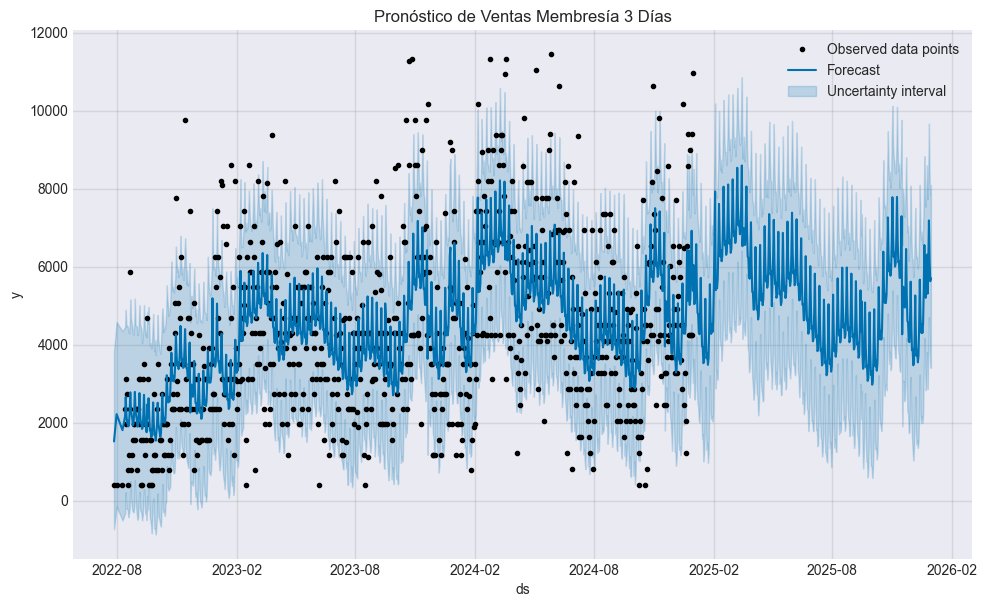

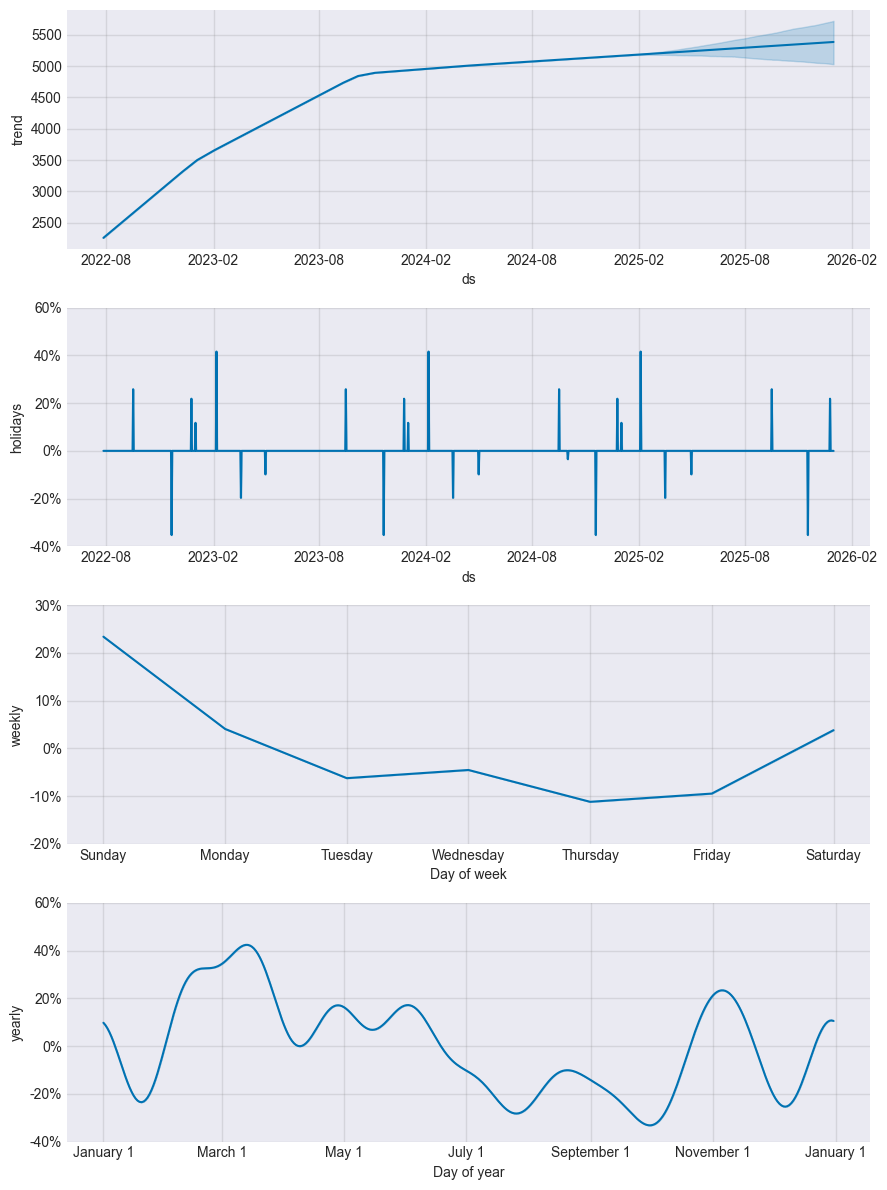

In [67]:
# 1. Gráfico principal: Puntos negros son datos reales, línea azul es la predicción
fig1 = m.plot(forecast)
plt.title("Pronóstico de Ventas Membresía 3 Días")
# mostrar leyenda
plt.legend()
plt.show()

# 2. Desglose de componentes: Muestra Tendencia, Semanal, Anual y Festivos por separado
fig2 = m.plot_components(forecast)
plt.show()

##### Agrupamos data por mes para su exportacion

In [68]:
# agrupar por mes y sumar yhat, yhat_lower, yhat_upper
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast['month'] = forecast['ds'].dt.to_period('M')
monthly_sales = forecast.groupby('month')[['yhat', 'yhat_lower', 'yhat_upper']].sum().round(2).reset_index()
print(monthly_sales)

      month       yhat  yhat_lower  yhat_upper
0   2022-07    3739.86     -883.67     8404.47
1   2022-08   39631.61    -2486.50    81766.87
2   2022-09   57170.60    -8067.01   121826.86
3   2022-10   78469.86    10603.94   144835.20
4   2022-11  100857.45    30897.37   170443.77
5   2022-12   90883.88    20762.39   160994.31
6   2023-01   99998.87    27369.60   171544.88
7   2023-02  131462.33    65328.19   197150.12
8   2023-03  158646.78    86386.68   229709.63
9   2023-04  130845.55    61475.64   202084.61
10  2023-05  142734.75    69190.57   214405.63
11  2023-06  133950.46    63764.44   203495.47
12  2023-07  110889.10    38126.68   182952.46
13  2023-08  120669.70    48010.05   192427.72
14  2023-09  110075.72    40042.66   180947.39
15  2023-10  136052.87    63354.29   208318.37
16  2023-11  158604.28    88262.31   228375.33
17  2023-12  138703.77    66190.56   211793.22
18  2024-01  137660.90    65269.14   209726.65
19  2024-02  181246.12   113375.79   249228.70
20  2024-03  

In [69]:
monthly_sales.to_csv("../data/data_forecast_2025_gold/forecast_7_dias_2025_monthly.csv")

In [70]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='90 days')

# 2. Calcular métricas de error
df_p = performance_metrics(df_cv)

# 3. Ver el resultado (Las métricas más importantes)
print(df_p[['horizon', 'rmse', 'mape']].head())

  0%|          | 0/1 [00:00<?, ?it/s]12:24:14 - cmdstanpy - INFO - Chain [1] start processing
12:24:14 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


  horizon         rmse      mape
0  9 days  2539.711259  2.141247
1 10 days  2819.724616  2.327345
2 11 days  3058.501553  2.434069
3 12 days  3209.749198  2.537400
4 13 days  3228.405724  2.559908
